In [ ]:
import pandas as pd
import numpy as np

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import (
    dynamic_feature_last_position_taken,
    dynamic_feature_real_position  # you can import it if you ever need it
)

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    nonstationary_prob_model, 
    make_ohlcv,
    FeatureEngineering,
    excess_return_metric,
    extract_signals,
)
from RLTrade.plot_utils import (
    build_fig,
    plot_signals_distribution,
    plot_metrics_subplots,
)

In [ ]:
x0, mu_epsilon = 100, 200

N, window, stride = 100000, 24, 24  # simulation with ohlc
# N, window, stride = 10000, 1, 1  # simulation with tick data

train_set_random_state = 42
x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=train_set_random_state)
y_o, y_h, y_l, y_c = make_ohlcv(y_c, window=window, stride=stride)
x_o, x_h, x_l, x_c = make_ohlcv(x_c, window=window, stride=stride)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
# spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 5,  # sidetrack: the rolling window mean correction can somehow help detect mean shift
       'mode': 'diff',
     }},
]

fe = FeatureEngineering(df)
df_train = fe.build_features(feature_config)

# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_prob_model",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1.]
Market Return :  7.31%   |   Portfolio Return : -36.49%   |   Excess Return : -54.0%   |   Position Changes : 2819   |   Episode Length : 4166   |   


In [ ]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations, n_actions, target_net_layers=[32, 32], policy_net_layers=[32, 32],)
history_metrics_list = []

for i_simulation in range(50):
    x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=i_simulation*4201)
    y_o, y_h, y_l, y_c = make_ohlcv(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlcv(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk
    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    df_train = fe.df.copy()

    # Define the environment
    env = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = df_train, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
            # max_episode_duration=180
        )
    env.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
    env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    history_metrics, _ = agent.train(env, num_episodes=1) # One episode is one simulation
    history_metrics_list += history_metrics

Market Return : -4.51%   |   Portfolio Return : -19.67%   |   Excess Return : -17.76%   |   Position Changes : 2471   |   Episode Length : 4166   |   
Market Return : 25.16%   |   Portfolio Return : 14.71%   |   Excess Return : -9.24%   |   Position Changes : 2046   |   Episode Length : 4166   |   
Market Return : -7.15%   |   Portfolio Return :  4.28%   |   Excess Return : 10.81%   |   Position Changes : 1988   |   Episode Length : 4166   |   
Market Return : -2.85%   |   Portfolio Return : 13.76%   |   Excess Return : 15.26%   |   Position Changes : 1987   |   Episode Length : 4166   |   
Market Return : -4.44%   |   Portfolio Return : 69.87%   |   Excess Return : 57.02%   |   Position Changes : 2038   |   Episode Length : 4166   |   
Market Return :  4.30%   |   Portfolio Return : 49.87%   |   Excess Return : 35.77%   |   Position Changes : 1964   |   Episode Length : 4166   |   
Market Return : -17.14%   |   Portfolio Return : 31.76%   |   Excess Return : 45.76%   |   Position Chan

In [ ]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []

perc2float = lambda x: float(x.strip('%'))/100
for i in range(10):
    x_c, y_c = nonstationary_prob_model(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlcv(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlcv(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_prob_model_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Excess Return', lambda history: f"{np.round(excess_return_metric(history) * 100, 2)}%")
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -4.51%   |   Portfolio Return : 74.91%   |   Excess Return : 59.95%   |   Position Changes : 1616   |   Episode Length : 4166   |   
Market Return : -10.55%   |   Portfolio Return : 68.54%   |   Excess Return : 62.68%   |   Position Changes : 1654   |   Episode Length : 4166   |   
Market Return : -13.03%   |   Portfolio Return : 69.79%   |   Excess Return : 66.23%   |   Position Changes : 1602   |   Episode Length : 4166   |   
Market Return : -14.90%   |   Portfolio Return : 59.79%   |   Excess Return : 61.41%   |   Position Changes : 1625   |   Episode Length : 4166   |   
Market Return : -0.59%   |   Portfolio Return : 36.00%   |   Excess Return : 30.96%   |   Position Changes : 1683   |   Episode Length : 4166   |   
Market Return : 25.96%   |   Portfolio Return : 14.95%   |   Excess Return : -9.64%   |   Position Changes : 1662   |   Episode Length : 4166   |   
Market Return :  3.77%   |   Portfolio Return : 35.76%   |   Excess Return : 26.23%   |   Position Chan

In [7]:
historical_info_df = history_dfs[-1]
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_open', 'data_low', 'data_high', 'data_volume', 'data_close',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

In [8]:
buy_df_qlearning, sell_df_qlearning, exit_df_qlearning = extract_signals(historical_info_df)
fig_qlearning = build_fig(
    historical_info_df,
    buy_df_qlearning,
    sell_df_qlearning,
    exit_df_qlearning
)
fig_qlearning.show()

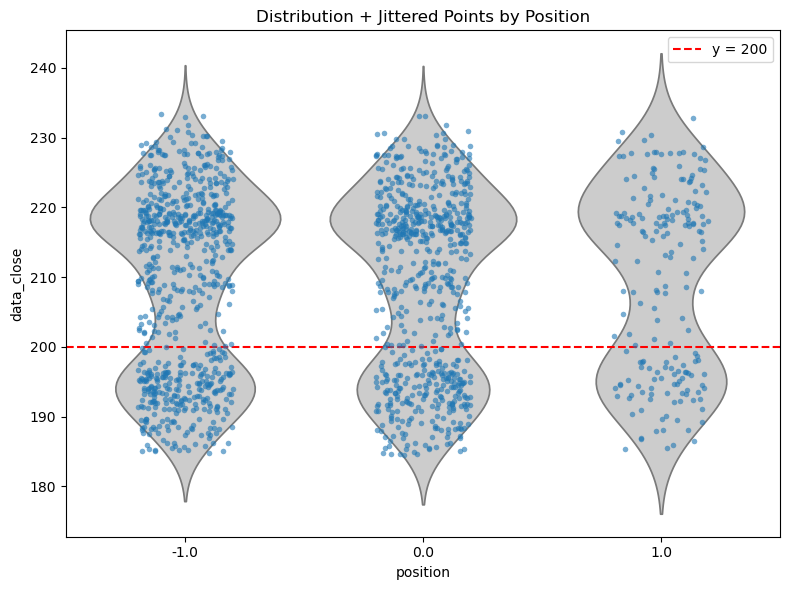

In [9]:
signals_df_qlearning = pd.concat([buy_df_qlearning, sell_df_qlearning, exit_df_qlearning])
plot_signals_distribution(signals_df_qlearning, threshold=mu_epsilon)

In [10]:
signals_df_qlearning["above"] = signals_df_qlearning["data_close"] > mu_epsilon
signals_df_qlearning.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,259,503
0.0,227,452
1.0,68,125
